# A Quick Look at ZTF Light Curves
This notebook demostrates how to search for ZTF light curve data using the cone-search API provided by [IRSA/IPAC](https://irsa.ipac.caltech.edu/docs/program_interface/ztf_lightcurve_api.html), and then goes through a few steps to perform a period identification before generating folded ZTF light curves

In [1]:
import numpy as np
import requests
from io import StringIO
from pandas import read_csv
from astropy.io import ascii
from astropy.timeseries import LombScargle as ls
import astropy.coordinates as coord
from astropy.coordinates import EarthLocation
from astropy.time import Time
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import lmfit as lmf
from lmfit import Model
%matplotlib inline

### Generate URL Request with Cone Search and Load Decoded Response into a Pandas DataFrame

In [2]:
# Search Coordinates
ra = 239.67747 # Search RA
dec = 51.26362 # Search Dec
rad = 0.001    # Search Radius in Degrees

# Generate URL to query the ZTF Light Curve Database
base_url = "https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?"
pos_string = "POS=CIRCLE {:.5f} {:.5f} {:.5f}&FORMAT=csv".format(ra,dec,rad)
search_url = base_url + pos_string

# Perform request and decode response into a Pandas DataFrame
response = requests.get(search_url)
data = read_csv(StringIO(response.content.decode('utf-8')))


### Separate into *g* & *r* Light Curves and filter out bad data points following the recommendations of [Guidry et al. 2020](https://ui.adsabs.harvard.edu/abs/2020arXiv201200035G/abstract)

In [3]:
gdata = data[(data.filtercode == 'zg') & 
             (data.catflags == 0) &
             (data.sharp > -0.25) & 
             (data.sharp < 0.25) & 
             (data.mag < data.limitmag-1.0)].sort_values(by='mjd').reset_index(drop=True)
rdata = data[(data.filtercode == 'zr') & 
             (data.catflags == 0) &
             (data.sharp > -0.25) & 
             (data.sharp < 0.25) &
             (data.mag < data.limitmag-1.0)].sort_values(by='mjd').reset_index(drop=True)
gdata = gdata[gdata.limitmag > gdata.mag.median()+1.0]
rdata = rdata[rdata.limitmag > rdata.mag.median()+1.0]

# Get Coordinates from one of the light curve entries
c = coord.SkyCoord(gdata.ra.iloc[0],gdata.dec.iloc[0],unit='deg',frame='icrs')
cstring = c.to_string('hmsdms',sep=':',precision=2)

### Calculate Barycentric Time Corrections for the time stamps of each data point
Given the long time-baseline covered by ZTF photometry, these corrections are vital for correct period identification, and for generating folded light curves

In [4]:
# Calculate the light travel times
loc_ztf = EarthLocation.of_site('palomar')
t_ztfg = Time(gdata.mjd.values,scale='utc',format='mjd',location=loc_ztf)
t_ztfr = Time(rdata.mjd.values,scale='utc',format='mjd',location=loc_ztf)
ltt_bary_ztfg = t_ztfg.light_travel_time(c)
ltt_bary_ztfr = t_ztfr.light_travel_time(c)

# Generate Time Arrays in BJD format for each dataset (rescaled UTC + LTT)
tbjd_ztfg = t_ztfg.tdb.jd + ltt_bary_ztfg.jd
tbjd_ztfr = t_ztfr.tdb.jd + ltt_bary_ztfr.jd
bjdref = min(min(tbjd_ztfg),min(tbjd_ztfr)) 

# Add BJD times to Dataframes
gdata['bjd'] = tbjd_ztfg
rdata['bjd'] = tbjd_ztfr

### Plot the ZTF Light Curves

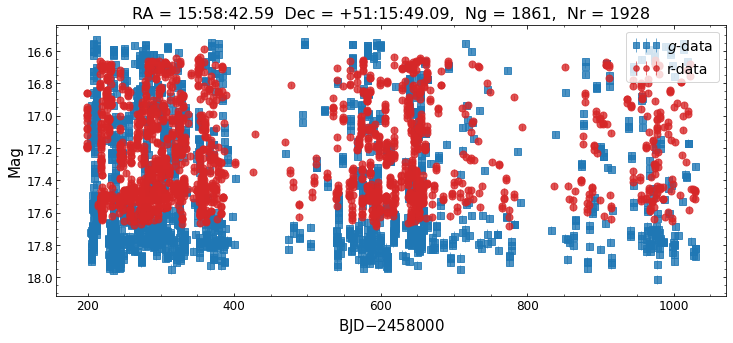

In [5]:
figa = plt.figure('a',figsize=(12,5))
ax = figa.add_subplot(111)

# Plot g & r data
ax.errorbar(gdata.bjd-2458000,gdata.mag,yerr=gdata.magerr,
            ls='None',marker='s',ms=7,mfc='C0',mec='C0',
            ecolor='C0',elinewidth=0.75,alpha=0.8)
ax.errorbar(rdata.bjd-2458000,rdata.mag,yerr=rdata.magerr,
            ls='None',marker='o',ms=7,mfc='C3',mec='C3',
            ecolor='C3',elinewidth=0.75,alpha=0.8)

# Set Plot Appearances
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xlabel('BJD$-$2458000',fontsize=15)
ax.set_ylabel('Mag',fontsize=15)
ax.minorticks_on()
ax.tick_params(which='both',axis='both',direction='in',
               right=True,top=True,labelsize=12)
ax.legend(('$\it{g}$-data','r-data'),fontsize=14,
           handletextpad=0.5,numpoints=3,markerscale=0.8)

# Create Plot Title With Coordinates and Data Counts
title_a = 'RA = {}  Dec = {},  Ng = {},  Nr = {}'.format(cstring.split(" ")[0],cstring.split(" ")[1],
                                                        len(gdata),len(rdata))
ax.set_title(title_a,fontsize=16);

### Convert Light Curves into Fractional Flux Change Relative to Median Magnitudes

In [6]:
# Convert times to seconds relative to earliest data point
tsg = (gdata.bjd.values - bjdref) * 86400.0
tsr = (rdata.bjd.values - bjdref) * 86400.0
sort_ind = np.argsort(np.concatenate((tsg,tsr)))
tsa = np.concatenate((tsg,tsr))[sort_ind]

# Normalize the magnitudes
gmag_norm = 10.0**(0.4*(gdata.mag.median()-gdata.mag.values)) - 1.0
rmag_norm = 10.0**(0.4*(rdata.mag.median()-rdata.mag.values)) - 1.0
amag_norm = np.concatenate((gmag_norm,rmag_norm))[sort_ind]

# Calculate errors on normalized magnitudes
gmag_norm_err = gdata.magerr.values / 1.086
rmag_norm_err = rdata.magerr.values / 1.086
amag_norm_err = np.concatenate((gmag_norm_err,rmag_norm_err))[sort_ind]


### Calculate Lomb Scargle Periodgrams for the *g, r*, and combined ZTF Light Curves

In [7]:
# Function to Calculate Lomb-Scargle Periodogram (LSP) with Amplitude Units
def calc_lsp(t,a,f):
    lsp = ls(t,a).power(f,normalization='psd')
    norm_lsp = np.sqrt(abs(4.0*(lsp/len(t))))
    return norm_lsp

# Calculate LSP for g, r, & combined light curves
fnyq = 0.005
fres = 1.0e-8
farr = np.linspace(1e-6,fnyq,int(fnyq/fres))
glsp = calc_lsp(tsg,gmag_norm,farr)
rlsp = calc_lsp(tsr,rmag_norm,farr)
alsp = calc_lsp(tsa,amag_norm,farr)

### Pick out the Maximum Frequency and optimize it using LMFIT

In [8]:
# Pick out the maximum frequency and amplitude
max_freq = farr[alsp == max(alsp)][0]
max_amp = max(alsp)

# Sinusoidal Function
def sine(x,freq,amp,phase):
    return amp*np.sin(2.0*np.pi*(freq*x + phase))

# A simple constant offset
def offset(x,offset):
    return offset

# Generate an LMFIT model and parameters
mod = Model(offset) + Model(sine)
par = mod.make_params()

# Set LMFIT initial values
par['offset'].value = 0.0
par['freq'].value = max_freq
par['amp'].value = max_amp
par['phase'].value = 0.0

# Fix independent frequencies initially for a linear least squares fit
par['freq'].vary = False

# Perform the linear LSQ fit
result = mod.fit(amag_norm, params=par, x=tsa)

# Now unfix the frequencies
new_par = result.params
new_par['freq'].vary = True
result = mod.fit(amag_norm, params=new_par, x=tsa)

# Save Fit Results
freq_vals = []
freq_errs = []
for name,param in result.params.items():
    if 'freq' in name:
        freq_vals.append(param.value)
        freq_errs.append(param.stderr)
print("  Initial Frequency: {:.6f} uHz".format(max_freq*1e6))
print("Optimized Frequency: {:.6f} uHz".format(freq_vals[0]*1e6))
print("  Initial Period   : {:.4f} hr".format(1./max_freq/3600))
print("Optimized Period   : {:.4f} hr".format(1./freq_vals[0]/3600))

# Subtract LMFIT model from the observed flux and recalculate the LS-Periodogram
amag_norm_pw = np.copy(amag_norm) - result.best_fit
alsp_pw = calc_lsp(tsa,amag_norm_pw,farr)

  Initial Frequency: 18.596515 uHz
Optimized Frequency: 18.598634 uHz
  Initial Period   : 14.9371 hr
Optimized Period   : 14.9354 hr


### Plot the Normalized ZTF Light Curves and Lomb-Scargle Periodograms

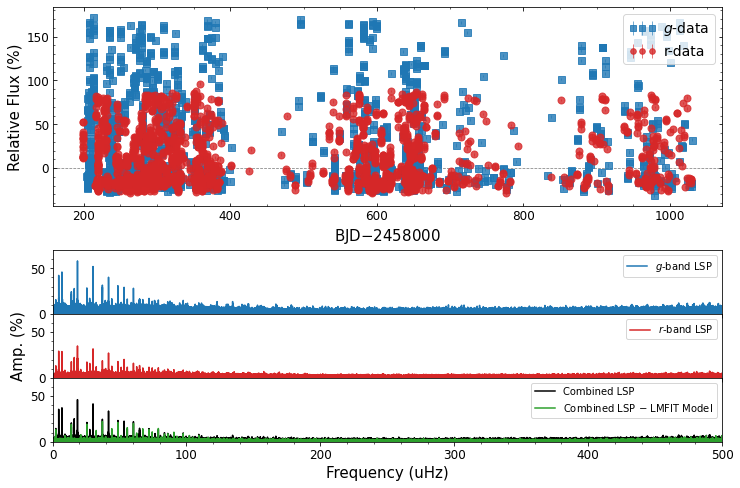

In [9]:
figb = plt.figure('b',figsize=(12,8))
gsb = GridSpec(5,1,height_ratios=[2.5,0.55,0.8,0.8,0.8],hspace=0)
bx0 = figb.add_subplot(gsb[0])
bx1 = figb.add_subplot(gsb[2])
bx2 = figb.add_subplot(gsb[3])
bx3 = figb.add_subplot(gsb[4])

# Plot Normalized g & r Flux 
bx0.errorbar(gdata.bjd-2458000,gmag_norm*1e2,yerr=gmag_norm_err*1e2,
             ls='None',marker='s',ms=7,mfc='C0',mec='C0',
             ecolor='C0',elinewidth=0.75,alpha=0.8)
bx0.errorbar(rdata.bjd-2458000,rmag_norm*1e2,yerr=rmag_norm_err*1e2,
             ls='None',marker='o',ms=7,mfc='C3',mec='C3',
             ecolor='C3',elinewidth=0.75,alpha=0.8)
bx0.axhline(0,ls='--',c='k',lw=0.75,alpha=0.5,label='_nolegend_')

# Plot the Lomb-Scargle Periodograms
bx1.plot(farr*1e6,glsp*1e2,ls='-',c='C0',label='$g$-band LSP')
bx2.plot(farr*1e6,rlsp*1e2,ls='-',c='C3',label='$r$-band LSP')
bx3.plot(farr*1e6,alsp*1e2,ls='-',c='k',label='Combined LSP')
bx3.plot(farr*1e6,alsp_pw*1e2,ls='-',c='C2',label='Combined LSP $-$ LMFIT Model')

# Set Plot Appearances
bx0.set_xlabel('BJD$-$2458000',fontsize=15)
bx0.set_ylabel('Relative Flux (%)',fontsize=15)
bx3.set_xlabel('Frequency (uHz)',fontsize=15)
bx2.set_ylabel('Amp. (%)',fontsize=15)
bx1.set_xlim(0,500)
bx2.set_xlim(bx1.get_xlim())
bx3.set_xlim(bx1.get_xlim())
bx1.set_ylim(0,1.2*max([max(glsp),max(rlsp),max(alsp)])*1e2)
bx2.set_ylim(bx1.get_ylim())
bx3.set_ylim(bx1.get_ylim())
bx0.minorticks_on()
bx1.minorticks_on()
bx2.minorticks_on()
bx3.minorticks_on()
bx0.tick_params(which='both',axis='both',direction='in',
                right=True,top=True,labelbottom=True ,labelsize=12)
bx1.tick_params(which='both',axis='both',labelbottom=False,labelsize=12)
bx2.tick_params(which='both',axis='both',labelbottom=False,labelsize=12)
bx3.tick_params(which='both',axis='both',labelbottom=True ,labelsize=12)
bx0.legend(('$\it{g}$-data','r-data'),fontsize=14,
           handletextpad=0.5,numpoints=3,markerscale=0.8)
bx1.legend()
bx2.legend()
bx3.legend();

### Convert ZTF Times to Phases using the LMFIT result as a folding period

In [10]:
# Designate a folding period using the result from LMFIT
pfold = 1./freq_vals[0]

# Calculate the phases
phases_g = (tsg / pfold) % 1.0
phases_r = (tsr / pfold) % 1.0

print('Folding Freq.  = {:.3f} uHz'.format(max_freq*1e6))
print('Folding Period = {:.3f} hr'.format(pfold/3600))

Folding Freq.  = 18.597 uHz
Folding Period = 14.935 hr


### Plot Two Cycles of the Phase Folded ZTF Light Curve

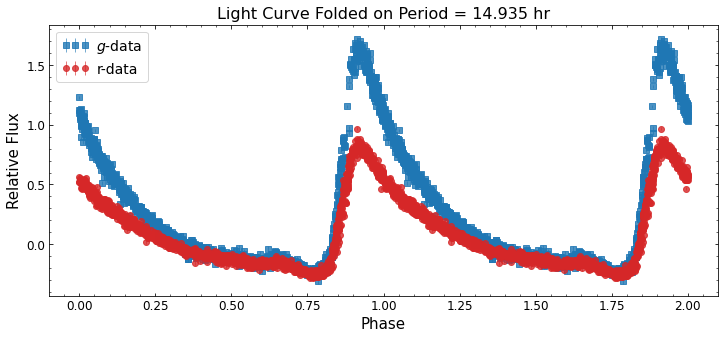

In [11]:
figc = plt.figure('c',figsize=(12,5))
cx = figc.add_subplot(111)

# Plot the Phase Folded ZTF Light Curves
for i in range(2):
    cx.errorbar(phases_g+float(i),gmag_norm,yerr=gmag_norm_err,
                ls='None',marker='s',ms=6,mfc='C0',mec='C0',
                ecolor='C0',elinewidth=0.75,alpha=0.8)
    cx.errorbar(phases_r+float(i),rmag_norm,yerr=rmag_norm_err,
                ls='None',marker='o',ms=6,mfc='C3',mec='C3',
                ecolor='C3',elinewidth=0.75,alpha=0.8)

# Add Title Showing Folding Period and RA/Dec
title = 'Light Curve Folded on Period = {:.3f} hr'.format(pfold/3600)
cx.set_title(title,fontsize=16)

# Add a legend
cx.legend(('$\it{g}$-data','r-data'),fontsize=14,
           handletextpad=0.5,numpoints=3)

# Add xy-labels
cx.set_xlabel('Phase',fontsize=15)
cx.set_ylabel('Relative Flux',fontsize=15)
cx.minorticks_on()
cx.tick_params(which='both',axis='both',direction='in',
               right=True,top=True,labelsize=12)